In [40]:
import string
import nltk
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from IPython.core.display import clear_output
import pandas_market_calendars as mcal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tag import pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63993/2172723741.py:10: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [2]:
articles = pd.read_csv( "../data/full_article2.txt", index_col=None, header=None, engine='python')
articles.columns = ['Symbol', 'Article', 'Month-Day', 'Year']
articles['Year'] = articles['Year'].astype(str)
articles['Date'] = articles['Month-Day'] + " " + articles['Year']
articles['Date'] = articles['Date'].str.strip()
articles['Date'] = articles['Date'].str.slice(start = 2, stop = 13)
articles['Date'] = articles['Date'].str.strip()
articles = articles[['Symbol', 'Article', 'Date']]
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,Mar 22 2022
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,Mar 22 2022
2,MO,The members of this alcohol and tobacco indus...,Mar 17 2022
3,MO,(Reuters) - An administrative law judge dismi...,Feb 24 2022
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,Feb 15 2022
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,Jun 25 2015
62475,ZTS,Investing.com – U.S. stocks were lower after ...,Jun 25 2015
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,Apr 27 2015
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,Mar 09 2015


In [8]:
articles['Symbol'].unique()

array(['MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AMT',
       'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM',
       'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ',
       'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL',
       'BAC', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB',
       'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO',
       'BR', 'BRO', 'BF.B', 'CHRW', 'CDNS', 'CZR', 'CPB', 'COF', 'CAH',
       'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE',
       'CNC', 'CNP', 'CDAY', 'CERN', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX',
       'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG',
       'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA',
       'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST',
       'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA',
       'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', '

In [4]:
articles.at[articles[articles['Date'].str.contains('hours') == True].index, 'Date'] = 'Apr 06 2022'
articles = articles[articles['Date'].str.len() == 11]
articles = articles[articles['Date'].str.contains("minutes") == False]
articles['Date'] = pd.to_datetime(articles['Date'], format = '%b %d %Y')
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [5]:
df = articles.copy()
df

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [6]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    sentence = []
    for word, tag in tokens:
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v' 
        else:
            pos = 'a'
        sentence.append(lemmatizer.lemmatize(word, pos))
    return sentence

In [9]:
df['title/no_stopwords'] = df.apply(lambda row: pos_tag(word_tokenize(row['Article'])), axis = 1)
df['title/no_stopwords'] = df.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[The, other, big, story, Monday, be, oil, stor..."
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[By, Peter, NurseInvesting.com, --, Stocks, in..."
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[The, member, of, this, alcohol, and, tobacco,..."
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[(, Reuters, ), -, An, administrative, law, ju..."
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[WASHINGTON, (, Reuters, ), -A, judge, at, the..."
...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[(, Reuters, ), -, Canada-based, drugmaker, Va..."
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[Investing.com, –, U.S., stock, be, low, after..."
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[By, David, RandallNEW, YORK, (, Reuters, ), -..."
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[By, Svea, Herbst-BaylissBOSTON, (, Reuters, )..."


In [10]:
def remove_noise(reviews, stop_words = ()):

    cleaned_tokens = []

    for token in reviews:
        token = token.strip()
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = token.replace('--', '')
        token = token.replace('-', '')
        token = token.replace('–', '')
        token = token.replace('investing.com', '')
        token = token.replace('``', '')
        token = token.replace("'s", '')
        token = token.replace('..', '')
        token = token.replace('...', '')
        token = token.replace("'", '')
        token = token.replace("’",'')
        token = token.replace("reuters", "")
        token = token.replace("say", "")
        token = token.replace("company", "")
        token = token.replace("inc", "")

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [11]:
stop_words = list(stopwords.words('english'))
df['title/no_stopwords'] = df.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl..."
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[peter, nurseinvesting.com, stocks, focus, pre..."
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[member, alcohol, tobacco, industrybacked, mar..."
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[reuters, administrative, law, judge, dismiss,..."
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, reuters, judge, u.s., federal, tr..."
...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[reuters, canadabased, drugmaker, valeant, pha..."
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[investing.com, u.s., stock, low, close, thurs..."
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, reuters, nasdaq, com..."
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, herbstbaylissboston, reuters, billionai..."


In [12]:
df['title/clean'] = df.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
df

,Symbol,Article,Date,title/no_stopwords,title/clean
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[peter, nurseinvesting.com, stocks, focus, pre...",peter nurseinvesting.com stocks focus premarke...
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[member, alcohol, tobacco, industrybacked, mar...",member alcohol tobacco industrybacked marijuan...
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[reuters, administrative, law, judge, dismiss,...",reuters administrative law judge dismiss feder...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, reuters, judge, u.s., federal, tr...",washington reuters judge u.s. federal trade co...
...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[reuters, canadabased, drugmaker, valeant, pha...",reuters canadabased drugmaker valeant pharmace...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[investing.com, u.s., stock, low, close, thurs...",investing.com u.s. stock low close thursday lo...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, reuters, nasdaq, com...",david randallnew york reuters nasdaq composite...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, herbstbaylissboston, reuters, billionai...",svea herbstbaylissboston reuters billionaire i...


In [48]:
df.iloc[0]['article/clean']

'big story monday oil storm high 6 decline last week brent crude close 8 west texas intermediate post 7 gain obvious talk point european union mull russian oil embargo addition sanction already place gasoline price average well 4 gallon united states bet consumer get hit hard wallet.24/7 wall st. review dozen analyst research report day week goal find fresh idea investor trader alike daily analyst call cover stock buy call cover stock sell avoid remember single analyst call ever use basis buy sell stock consensus analyst target data refinitiv.these top analyst upgrade downgrade initiation see tuesday march 22 2022.accenture plc nyse acn baird designate stock “ fresh pick ” shortterm trading call firm analyst keep neutral rating raise target price 360 350 last trade monday report 324.50.altria group inc. nyse mo goldman sachs raise neutral rating tobacco giant buy boost 48 target price 57 consensus target 54.08 stock close monday 52.25.american airlines group inc. nasdaq aal goldman sac

In [13]:
def get_quarterly_dates(row):
    quarterly_dates = np.array(['03-31', '06-30', '09-30', '12-31'])
    current_date = str(row['Date'])
    year = current_date[:5]
    current_date = current_date[5:10]
    new_date = quarterly_dates[quarterly_dates >= current_date]
    new_date = min(new_date)
    return year + new_date

In [14]:
df['quarterlyDateEnding'] = df.apply(get_quarterly_dates, axis = 1)
df

,Symbol,Article,Date,title/no_stopwords,title/clean,quarterlyDateEnding
0,MO,The other big story Monday was oil storming h...,2022-03-22,"[big, story, monday, oil, storm, high, 6, decl...",big story monday oil storm high 6 decline last...,2022-03-31
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,"[peter, nurseinvesting.com, stocks, focus, pre...",peter nurseinvesting.com stocks focus premarke...,2022-03-31
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,"[member, alcohol, tobacco, industrybacked, mar...",member alcohol tobacco industrybacked marijuan...,2022-03-31
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,"[reuters, administrative, law, judge, dismiss,...",reuters administrative law judge dismiss feder...,2022-03-31
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,"[washington, reuters, judge, u.s., federal, tr...",washington reuters judge u.s. federal trade co...,2022-03-31
...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,"[reuters, canadabased, drugmaker, valeant, pha...",reuters canadabased drugmaker valeant pharmace...,2015-06-30
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,"[investing.com, u.s., stock, low, close, thurs...",investing.com u.s. stock low close thursday lo...,2015-06-30
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,"[david, randallnew, york, reuters, nasdaq, com...",david randallnew york reuters nasdaq composite...,2015-06-30
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,"[svea, herbstbaylissboston, reuters, billionai...",svea herbstbaylissboston reuters billionaire i...,2015-03-31


In [15]:
# groupby symbol and quarterlyDateEnding to combine title into one document
new_df = df.groupby(['Symbol', 'quarterlyDateEnding'])['title/clean'].apply(" ".join).reset_index()
new_df

,Symbol,quarterlyDateEnding,title/clean
0,AAL,2015-03-31,jeffrey dastinnew york reuters united airlines...
1,AAL,2015-06-30,alwyn scottmiami reuters air traveler familiar...
2,AAL,2015-09-30,alwyn scottmobile ala. reuters airbus group pa...
3,AAL,2015-12-31,reuters united airlines wednesday cancel fligh...
4,AAL,2016-03-31,jeffrey dastin reuters u.s. airline hop get li...
...,...,...,...
4378,ZTS,2018-09-30,aparajita saxena reuters eli lilly unit elanco...
4379,ZTS,2018-12-31,investing.com zoetis inc nyse zts report third...
4380,ZTS,2021-09-30,jefferies nyse jef analyst david steinberg mai...
4381,ZTS,2021-12-31,rodrigo gutierrez gerardo gomez reuters buin z...


In [16]:
vectorizer = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit_transform(new_df['title/clean'].tolist())
tfidf = tfidf.toarray()
tfidf

array([[0.        , 0.        , 0.        , ..., 0.05594053, 0.        ,
        0.0267683 ],
       [0.        , 0.00792221, 0.02387033, ..., 0.00797417, 0.00731283,
        0.06410459],
       [0.04418031, 0.01360391, 0.0204949 , ..., 0.        , 0.        ,
        0.03210652],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06844593],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02621243,
        0.0574448 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05378341]])

In [17]:
tfidf_pd = pd.DataFrame(tfidf)
tfidf_pd['Symbol'] = new_df['Symbol']
tfidf_pd['quarterlyDateEnding'] = new_df['quarterlyDateEnding']
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058301,0.008776,0.0,0.069763,0.055941,0.000000,0.026768,AAL,2015-03-31
1,0.000000,0.007922,0.023870,0.015014,0.007912,0.006523,0.014800,0.000000,0.000000,0.000000,...,0.000000,0.021154,0.000000,0.0,0.078894,0.007974,0.007313,0.064105,AAL,2015-06-30
2,0.044180,0.013604,0.020495,0.006446,0.006794,0.005600,0.019061,0.014017,0.006862,0.070075,...,0.007282,0.018163,0.000000,0.0,0.091645,0.000000,0.000000,0.032107,AAL,2015-09-30
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054937,0.000000,0.0,0.048208,0.000000,0.000000,0.000000,AAL,2015-12-31
4,0.009462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.032748,0.068071,0.011271,0.0,0.107519,0.030791,0.000000,0.041255,AAL,2016-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.161122,0.000000,0.0,0.040396,0.000000,0.000000,0.116250,ZTS,2018-09-30
4379,0.000000,0.000000,0.000000,0.067381,0.071018,0.058545,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047468,0.000000,0.0,0.124962,0.000000,0.000000,0.047948,ZTS,2018-12-31
4380,0.000000,0.000000,0.000000,0.000000,0.000000,0.020893,0.023704,0.000000,0.025599,0.000000,...,0.027166,0.067761,0.000000,0.0,0.074326,0.000000,0.000000,0.068446,ZTS,2021-09-30
4381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026526,0.000000,0.000000,0.000000,...,0.000000,0.056870,0.000000,0.0,0.066539,0.000000,0.026212,0.057445,ZTS,2021-12-31


In [18]:
prices = pd.read_csv("../data/monthly_prices.csv")
prices.columns = ['Date', 'open', 'high', 'low', 'close', 'volume', 'Symbol']
prices

,Date,open,high,low,close,volume,Symbol
0,2022-01-21,178.32,181.780,172.5600,172.65,34039389,MMM
1,2021-12-31,172.55,179.180,169.1801,177.63,48251474,MMM
2,2021-11-30,178.53,186.300,169.9400,170.04,47872133,MMM
3,2021-10-29,176.25,183.820,173.7800,178.68,48241875,MMM
4,2021-09-30,194.55,195.606,175.3700,175.42,67366254,MMM
...,...,...,...,...,...,...,...
118000,2013-07-31,31.02,31.650,28.9700,29.81,157249700,ZTS
118001,2013-06-28,32.01,32.990,29.4000,30.89,292403400,ZTS
118002,2013-05-31,32.97,34.280,31.7500,32.00,72809400,ZTS
118003,2013-04-30,33.42,34.740,30.4200,33.02,42045100,ZTS


In [19]:
# add prices to new_tfidf
new_tfidf = tfidf_pd.copy()
new_tfidf['Price'] = np.nan
for i in new_tfidf.index:
    symbol = new_tfidf.loc[i]['Symbol']
    #print(symbol)
    date = new_tfidf.loc[i]['quarterlyDateEnding']
    year_month = date[:7]
    tmp = prices[prices['Symbol'] == symbol]
    new_tmp = tmp[tmp['Date'].str.contains(year_month)]
    #print(tmp['Date'].str.contains(year_month) == True)
    #print(len(new_tmp))
    if len(new_tmp) == 0:
        continue
    new_tfidf.at[i, 'Price'] = new_tmp.iloc[0]['close']
new_tfidf

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058301,0.008776,0.0,0.069763,0.055941,0.000000,0.026768,AAL,2015-03-31,52.780
1,0.000000,0.007922,0.023870,0.015014,0.007912,0.006523,0.014800,0.000000,0.000000,0.000000,...,0.021154,0.000000,0.0,0.078894,0.007974,0.007313,0.064105,AAL,2015-06-30,39.935
2,0.044180,0.013604,0.020495,0.006446,0.006794,0.005600,0.019061,0.014017,0.006862,0.070075,...,0.018163,0.000000,0.0,0.091645,0.000000,0.000000,0.032107,AAL,2015-09-30,38.830
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054937,0.000000,0.0,0.048208,0.000000,0.000000,0.000000,AAL,2015-12-31,42.350
4,0.009462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068071,0.011271,0.0,0.107519,0.030791,0.000000,0.041255,AAL,2016-03-31,41.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.161122,0.000000,0.0,0.040396,0.000000,0.000000,0.116250,ZTS,2018-09-30,91.560
4379,0.000000,0.000000,0.000000,0.067381,0.071018,0.058545,0.000000,0.000000,0.000000,0.000000,...,0.047468,0.000000,0.0,0.124962,0.000000,0.000000,0.047948,ZTS,2018-12-31,85.540
4380,0.000000,0.000000,0.000000,0.000000,0.000000,0.020893,0.023704,0.000000,0.025599,0.000000,...,0.067761,0.000000,0.0,0.074326,0.000000,0.000000,0.068446,ZTS,2021-09-30,194.140
4381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026526,0.000000,0.000000,0.000000,...,0.056870,0.000000,0.0,0.066539,0.000000,0.026212,0.057445,ZTS,2021-12-31,244.030


In [20]:
nona_tfidf = new_tfidf.dropna()
nona_tfidf

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058301,0.008776,0.0,0.069763,0.055941,0.000000,0.026768,AAL,2015-03-31,52.780
1,0.000000,0.007922,0.023870,0.015014,0.007912,0.006523,0.014800,0.000000,0.000000,0.000000,...,0.021154,0.000000,0.0,0.078894,0.007974,0.007313,0.064105,AAL,2015-06-30,39.935
2,0.044180,0.013604,0.020495,0.006446,0.006794,0.005600,0.019061,0.014017,0.006862,0.070075,...,0.018163,0.000000,0.0,0.091645,0.000000,0.000000,0.032107,AAL,2015-09-30,38.830
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054937,0.000000,0.0,0.048208,0.000000,0.000000,0.000000,AAL,2015-12-31,42.350
4,0.009462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068071,0.011271,0.0,0.107519,0.030791,0.000000,0.041255,AAL,2016-03-31,41.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.078713,0.000000,0.0,0.172679,0.000000,0.000000,0.066257,ZTS,2018-06-30,85.190
4378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.161122,0.000000,0.0,0.040396,0.000000,0.000000,0.116250,ZTS,2018-09-30,91.560
4379,0.000000,0.000000,0.000000,0.067381,0.071018,0.058545,0.000000,0.000000,0.000000,0.000000,...,0.047468,0.000000,0.0,0.124962,0.000000,0.000000,0.047948,ZTS,2018-12-31,85.540
4380,0.000000,0.000000,0.000000,0.000000,0.000000,0.020893,0.023704,0.000000,0.025599,0.000000,...,0.067761,0.000000,0.0,0.074326,0.000000,0.000000,0.068446,ZTS,2021-09-30,194.140


In [21]:
# add previous quarter prices to df
nona_tfidf['prevPrice'] = np.nan
d = {'-03' : '-12', '-06' : '-03', '-09' : '-06', '-12' : '-09'}
for i in nona_tfidf.index:
    symbol = new_tfidf.loc[i]['Symbol']
    #print(symbol)
    date = new_tfidf.loc[i]['quarterlyDateEnding']
    year_month = date[:7]
    month = date[4:7]
    year = date[:4]
    tmp = prices[prices['Symbol'] == symbol]
    new_tmp = tmp[tmp['Date'].str.contains(year + d[month])]
    if len(new_tmp) == 0:
        continue
    nona_tfidf.at[i, 'prevPrice'] = new_tmp.iloc[0]['close']
nona_tfidf = nona_tfidf.dropna()
nona_tfidf

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_63993/567317927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nona_tfidf['prevPrice'] = np.nan


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price,prevPrice
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008776,0.0,0.069763,0.055941,0.000000,0.026768,AAL,2015-03-31,52.780,42.350
1,0.000000,0.007922,0.023870,0.015014,0.007912,0.006523,0.014800,0.000000,0.000000,0.000000,...,0.000000,0.0,0.078894,0.007974,0.007313,0.064105,AAL,2015-06-30,39.935,52.780
2,0.044180,0.013604,0.020495,0.006446,0.006794,0.005600,0.019061,0.014017,0.006862,0.070075,...,0.000000,0.0,0.091645,0.000000,0.000000,0.032107,AAL,2015-09-30,38.830,39.935
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.048208,0.000000,0.000000,0.000000,AAL,2015-12-31,42.350,38.830
4,0.009462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011271,0.0,0.107519,0.030791,0.000000,0.041255,AAL,2016-03-31,41.010,46.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.172679,0.000000,0.000000,0.066257,ZTS,2018-06-30,85.190,83.510
4378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.040396,0.000000,0.000000,0.116250,ZTS,2018-09-30,91.560,85.190
4379,0.000000,0.000000,0.000000,0.067381,0.071018,0.058545,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.124962,0.000000,0.000000,0.047948,ZTS,2018-12-31,85.540,91.560
4380,0.000000,0.000000,0.000000,0.000000,0.000000,0.020893,0.023704,0.000000,0.025599,0.000000,...,0.000000,0.0,0.074326,0.000000,0.000000,0.068446,ZTS,2021-09-30,194.140,186.360


In [22]:
date_split = '2018-09-30'
X_train = nona_tfidf[nona_tfidf['quarterlyDateEnding'] < date_split].drop(['quarterlyDateEnding', 'Symbol', 'Price'], axis = 1)
y_train = nona_tfidf[nona_tfidf['quarterlyDateEnding'] < date_split]['Price']
X_test = nona_tfidf[nona_tfidf['quarterlyDateEnding'] >= date_split].drop(['quarterlyDateEnding', 'Symbol', 'Price'], axis = 1)
y_test = nona_tfidf[nona_tfidf['quarterlyDateEnding'] >= date_split]['Price']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

2022-04-23 15:58:40.518855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
15/15 [==============================] - 1s 2ms/step - loss: 34895.1523 - mean_absolute_error: 106.3868
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 34649.1562 - mean_absolute_error: 105.9823
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 34261.9570 - mean_absolute_error: 105.2851
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 33222.0156 - mean_absolute_error: 103.6967
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 30829.9199 - mean_absolute_error: 99.2672
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 26338.1113 - mean_absolute_error: 90.2680
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 19660.9707 - mean_absolute_error: 76.0365
Epoch 8/10
15/15 [==============================] - 0s 2ms/step - loss: 11571.2734 - mean_absolute_error: 54.4949
Epoch 9/10
15/15 [==============================] - 0s 2ms/step - loss: 3720.9966 - 

# Two weeks after article

In [23]:
# predict price using tf-idf two weeks after article
vectorizer = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit_transform(df['title/clean'].tolist())
tfidf = tfidf.toarray()
tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03855735, 0.        ,
        0.0233631 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05949043],
       [0.09240725, 0.        , 0.05236734, ..., 0.        , 0.        ,
        0.08346638]])

In [24]:
tfidf_pd = pd.DataFrame(tfidf)
tfidf_pd['Symbol'] = df['Symbol']
tfidf_pd['currentDate'] = df['Date']
tfidf_pd['nextDate'] = df['Date'] + pd.DateOffset(days = 14)
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,Symbol,currentDate,nextDate
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.055949,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.097605,0.0,0.043471,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.050575,0.000000,0.0,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.018772,0.000000,0.0,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.105541,0.000000,0.0,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28


In [25]:
daily_prices = pd.read_csv('../data/daily_prices.csv')
daily_prices

,Date,Open,High,Low,Close,Volume,Symbol
0,2014-04-09,107.283329,107.974706,106.885983,107.950867,2671900.0,MMM
1,2014-04-10,107.863458,108.419740,106.409171,106.464806,2857200.0,MMM
2,2014-04-11,105.988008,106.361514,105.209213,105.209213,2368200.0,MMM
3,2014-04-14,106.051558,106.107193,104.915156,105.813148,2058100.0,MMM
4,2014-04-15,105.908540,106.766808,104.915176,106.560181,2119000.0,MMM
...,...,...,...,...,...,...,...
1000210,2022-04-04,191.139999,191.979996,187.179993,188.740005,2603600.0,ZTS
1000211,2022-04-05,188.740005,190.740005,187.690002,188.399994,2059300.0,ZTS
1000212,2022-04-06,188.160004,192.330002,186.520004,191.380005,2843500.0,ZTS
1000213,2022-04-07,191.199997,199.339996,190.970001,197.929993,2781400.0,ZTS


In [26]:
current_price = []
for i in range(len(tfidf_pd)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    subset = daily_prices[(daily_prices['Date'] <= str(tfidf_pd.iloc[i]['currentDate'])[0: 10]) & (tfidf_pd.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        current_price.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    current_price.append(subset.iloc[0]['Close'])
current_price[0]

52.40848159790039

In [27]:
tfidf_pd['currentPrice'] = current_price
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,Symbol,currentDate,nextDate,currentPrice
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.055949,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.097605,0.0,0.043471,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14,62.619530
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12,62.335152
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06,60.676292
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28,62.455280


In [15]:
# two weeks from current date
next_price = []
for i in range(len(tfidf_pd)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    next_date = tfidf_pd.iloc[i]['nextDate']
    next_date = str(next_date)[0:10]
    subset = daily_prices[(daily_prices['Date'] <= next_date) & (tfidf_pd.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        next_price.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    if subset.iloc[0]['Date'] <= str(tfidf_pd.iloc[i]['currentDate'] + pd.DateOffset(days = 7))[0:10]:
        next_price.append(np.nan)
        continue
    next_price.append(subset.iloc[0]['Close'])
next_price[0]

52.63999938964844

In [16]:
tfidf_pd['nextPrice'] = next_price
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextPrice
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,52.639999
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,52.639999
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.056316,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872,52.250000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728,50.363655
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.042601,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044,50.697903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.042277,0.000000,0.0,0.055699,XLNX,2017-08-31,2017-09-14,62.619530,64.306816
62385,0.106213,0.040101,0.00000,0.075941,0.039811,0.033545,0.0,0.040868,0.040078,0.000000,...,0.0,0.000000,0.000000,0.0,0.063958,XLNX,2017-08-29,2017-09-12,62.335152,61.614727
62386,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.085624,0.037235,0.0,0.022562,XLNX,2017-08-23,2017-09-06,60.676292,60.771084
62387,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.066905,0.000000,0.0,0.058765,XLNX,2017-07-14,2017-07-28,62.455280,60.023060


In [17]:
tfidf_pd = tfidf_pd.dropna()
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextPrice
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,52.639999
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,52.639999
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.056316,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872,52.250000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728,50.363655
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.042601,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044,50.697903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.042277,0.000000,0.0,0.055699,XLNX,2017-08-31,2017-09-14,62.619530,64.306816
62385,0.106213,0.040101,0.00000,0.075941,0.039811,0.033545,0.0,0.040868,0.040078,0.000000,...,0.0,0.000000,0.000000,0.0,0.063958,XLNX,2017-08-29,2017-09-12,62.335152,61.614727
62386,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.085624,0.037235,0.0,0.022562,XLNX,2017-08-23,2017-09-06,60.676292,60.771084
62387,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.066905,0.000000,0.0,0.058765,XLNX,2017-07-14,2017-07-28,62.455280,60.023060


In [50]:
tfidf_pd[tfidf_pd['currentDate'] < '2018-11-30']

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextMonthDate,nextMonthPrice
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.030287,0.000000,0.0,0.039904,MO,2018-11-29,2018-12-13,43.155605,2018-12-29,38.341629
99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.106265,0.000000,0.0,0.028001,MO,2018-11-28,2018-12-12,42.391853,2018-12-28,38.341629
100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.047647,MO,2018-09-12,2018-09-26,48.316677,2018-10-12,46.334023
101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.050018,MO,2018-09-12,2018-09-26,48.316677,2018-10-12,46.334023
102,0.223014,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.119090,...,0.000000,0.000000,0.0,0.067146,MO,2018-09-12,2018-09-26,48.316677,2018-10-12,46.334023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14,62.619530,2017-09-30,67.141098
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12,62.335152,2017-09-28,66.534431
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06,60.676292,2017-09-22,65.719223
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28,62.455280,2017-08-13,59.169102


In [ ]:
date_split = '2018-12-30'
X_train = tfidf_pd[tfidf_pd['currentDate'] < date_split].drop(['currentDate', 'Symbol', 'nextPrice', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd[tfidf_pd['currentDate'] < date_split]['nextPrice']
X_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split].drop(['currentDate', 'Symbol', 'nextPrice', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split]['nextPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

In [214]:
# get MAE of neural network
model.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 715us/step - loss: 1859.2754 - mean_absolute_error: 14.9326


[1859.275390625, 14.932640075683594]

In [75]:
model.predict(X_test)

array([[ 52.306217],
       [ 51.634583],
       [ 50.020874],
       ...,
       [102.04226 ],
       [102.814064],
       [102.77375 ]], dtype=float32)

In [394]:
# invest 10000 evenly across top projected companies equally
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd.loc[X_test.index]['currentDate']
predicted['Symbol'] = tfidf_pd.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,48.494720,-0.486351,50.363655,2022-02-24,MO
4,49.469044,50.501450,2.086974,50.697903,2022-02-15,MO
5,49.488705,50.416595,1.874955,49.331409,2022-01-27,MO
6,49.488705,49.748322,0.524598,49.331409,2022-01-27,MO
7,43.000420,43.677185,1.573858,43.309078,2021-10-28,MO
...,...,...,...,...,...,...
62367,103.019936,104.239906,1.184208,109.857643,2019-01-24,XLNX
62368,103.019936,106.283051,3.167460,109.857643,2019-01-24,XLNX
62369,103.019936,104.089233,1.037952,109.857643,2019-01-24,XLNX
62370,103.019936,104.698601,1.629457,109.857643,2019-01-24,XLNX


In [395]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            test2 = test.history(start=d1, end = d2)
            test2 = test2.reset_index()
            test2 = test2[['Date', 'Close']]
            test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings
    

,Date,Close,Symbol,firstPrice,idx
0,2018-12-31,17.720114,WMB,17.720114,0
1,2019-01-02,18.017458,WMB,17.720114,0
2,2019-01-03,18.170147,WMB,17.720114,0
3,2019-01-04,18.925568,WMB,17.720114,0
4,2019-01-07,19.407743,WMB,17.720114,0
...,...,...,...,...,...
17,2022-03-24,16.719999,AAL,16.290001,262
18,2022-03-25,17.010000,AAL,16.290001,262
19,2022-03-28,17.299999,AAL,16.290001,262
20,2022-03-29,18.160000,AAL,16.290001,262


In [396]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == dates[i]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10025.170058
0,2019-01-03,10046.569828
0,2019-01-04,10152.442210
0,2019-01-07,10220.020305
...,...,...
0,2022-03-24,11949.583922
0,2022-03-25,11945.257434
0,2022-03-28,11879.722339
0,2022-03-29,11931.046473


In [397]:
spy = pd.read_csv("../data/SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

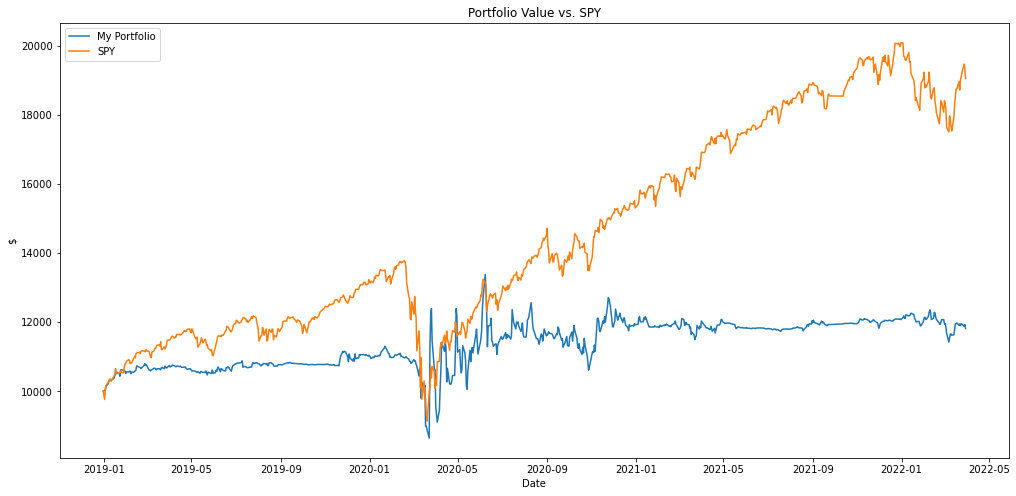

In [398]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# PCA Reduction

In [408]:
pca = PCA(n_components=500)
reduction = pca.fit_transform(tfidf_pd.drop(['currentDate', 'Symbol', 'nextPrice', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1))
df_reduction = pd.DataFrame(reduction)
df_reduction['currentDate'] = tfidf_pd['currentDate']
df_reduction['nextPrice'] = tfidf_pd['nextPrice']
df_reduction['currentPrice'] = tfidf_pd['currentPrice']
df_reduction

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,currentDate,nextPrice,currentPrice
0,-196.864167,0.085475,0.272503,-0.056292,0.065813,-0.006479,0.008237,-0.034191,-0.061811,0.066107,...,0.016909,-0.007482,-0.013773,-0.007360,-0.002253,-0.038662,-0.030606,2022-03-22,52.639999,52.408482
1,-196.864153,0.121480,0.024521,-0.017536,-0.153027,0.112520,0.065880,0.032218,0.076845,0.237240,...,-0.026019,-0.000669,0.041945,-0.028226,0.024682,-0.032088,-0.000546,2022-03-22,52.639999,52.408482
2,-198.456768,-0.140769,0.043890,0.013085,0.002704,0.059066,0.066594,-0.039932,-0.049968,-0.003248,...,0.050643,0.037070,-0.044295,0.025595,-0.011203,-0.059829,0.020448,2022-03-17,52.250000,50.815872
3,-200.540907,0.014363,-0.041319,-0.078953,0.002029,0.122614,0.012128,-0.028791,0.025921,0.165309,...,-0.028508,-0.029014,0.054083,-0.046238,0.038115,-0.015024,-0.013350,2022-02-24,50.363655,48.731728
4,-199.803590,-0.077609,-0.046575,-0.070348,-0.004427,0.086134,-0.015523,-0.030587,0.015800,0.166551,...,-0.028304,-0.058895,0.051761,-0.012030,0.006392,-0.007934,-0.036336,2022-02-15,50.697903,49.469044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61483,-186.653116,-0.085307,-0.118076,-0.138874,-0.112826,-0.230573,-0.199618,-0.097524,0.031432,-0.032554,...,-0.021667,0.007524,0.001143,-0.016215,-0.031893,-0.009508,-0.012806,2020-08-26,19.010004,19.037132
61484,-186.937506,0.617463,-0.106289,-0.241768,0.144412,-0.052967,-0.052561,-0.062386,-0.041446,-0.044297,...,0.015135,0.003479,0.000394,0.015942,-0.020049,-0.002982,-0.006026,2020-08-17,18.774868,20.203781
61485,-188.596335,-0.107237,-0.092870,-0.170507,-0.163493,-0.255654,0.034879,0.087130,-0.039217,0.106770,...,0.006546,0.015142,-0.034570,-0.002935,0.012892,-0.003121,0.021135,2020-08-16,19.055223,20.013863
61486,-186.817362,-0.174277,-0.059562,-0.092704,-0.160848,-0.201248,-0.243364,-0.089574,-0.014925,0.089724,...,0.003875,-0.035853,0.006032,-0.001496,0.016558,0.010557,-0.014665,2020-08-16,19.055223,20.013863


In [409]:
pca.explained_variance_ratio_.sum()

0.9999995008611398

In [410]:
date_split = '2018-12-30'
X_train = df_reduction[df_reduction['currentDate'] < date_split].drop(['currentDate', 'nextPrice',], axis = 1)
y_train = df_reduction[df_reduction['currentDate'] < date_split]['nextPrice']
X_test = df_reduction[df_reduction['currentDate'] >= date_split].drop(['currentDate', 'nextPrice'], axis = 1)
y_test = df_reduction[df_reduction['currentDate'] >= date_split]['nextPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(501, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
235/235 [==============================] - 1s 1ms/step - loss: 139385.0000 - mean_absolute_error: 164.8158
Epoch 2/10
235/235 [==============================] - 0s 1ms/step - loss: 138998.8281 - mean_absolute_error: 163.5942
Epoch 3/10
235/235 [==============================] - 0s 1ms/step - loss: 138460.8594 - mean_absolute_error: 161.9314
Epoch 4/10
235/235 [==============================] - 0s 974us/step - loss: 137805.0156 - mean_absolute_error: 159.8846
Epoch 5/10
235/235 [==============================] - 0s 982us/step - loss: 137032.4531 - mean_absolute_error: 157.4769
Epoch 6/10
235/235 [==============================] - 0s 984us/step - loss: 136156.4375 - mean_absolute_error: 154.6561
Epoch 7/10
235/235 [==============================] - 0s 985us/step - loss: 135195.3125 - mean_absolute_error: 151.5372
Epoch 8/10
235/235 [==============================] - 0s 978us/step - loss: 134159.1094 - mean_absolute_error: 148.1798
Epoch 9/10
235/235 [==========================

In [411]:
predicted = pd.DataFrame(tfidf_pd.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd.loc[X_test.index]['currentDate']
predicted['Symbol'] = tfidf_pd.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,26.703169,-45.203730,50.363655,2022-02-24,MO
4,49.469044,26.703169,-46.020447,50.697903,2022-02-15,MO
5,49.488705,26.703169,-46.041892,49.331409,2022-01-27,MO
7,43.000420,26.703169,-37.900213,43.309078,2021-10-28,MO
9,46.405338,26.703169,-42.456687,43.202976,2021-10-26,MO
...,...,...,...,...,...,...
61471,19.055223,26.703169,40.135690,18.650457,2020-08-28,WMB
61474,19.037132,26.703169,40.268862,19.010004,2020-08-26,WMB
61484,20.203781,26.703169,32.169165,18.774868,2020-08-17,WMB
61485,20.013863,26.703169,33.423365,19.055223,2020-08-16,WMB


In [415]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        nBought = 0
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            test2 = test.history(start=d1, end = d2)
            test2 = test2.reset_index()
            test2 = test2[['Date', 'Close']]
            test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings

,Date,Close,Symbol,firstPrice,idx
0,2018-12-31,19.853207,CTRA,19.853207,0
1,2019-01-02,20.901384,CTRA,19.853207,0
2,2019-01-03,20.768143,CTRA,19.853207,0
3,2019-01-04,20.546070,CTRA,19.853207,0
4,2019-01-07,21.381063,CTRA,19.853207,0
...,...,...,...,...,...
17,2022-03-24,17.049999,HPE,15.410000,626
18,2022-03-25,17.540001,HPE,15.410000,626
19,2022-03-28,17.379999,HPE,15.410000,626
20,2022-03-29,17.559999,HPE,15.410000,626


In [416]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == dates[i]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10026.398197
0,2019-01-03,10013.316390
0,2019-01-04,10028.962090
0,2019-01-07,10087.711154
...,...,...
0,2022-03-24,13056.339387
0,2022-03-25,12963.452528
0,2022-03-28,12797.742654
0,2022-03-29,12863.335753


In [417]:
spy = pd.read_csv("../data/SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

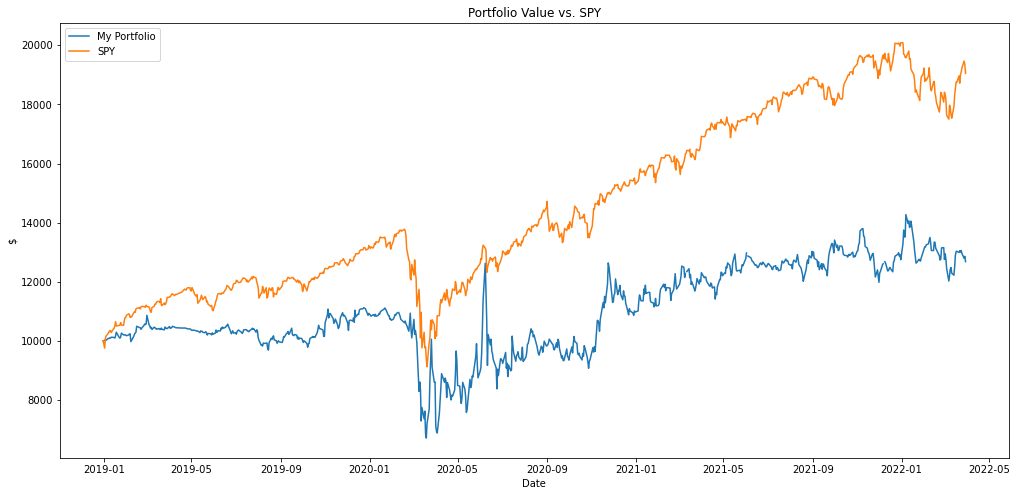

In [418]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# Regression Tree

In [419]:
model = DecisionTreeRegressor()
date_split = '2018-12-30'
X_train = tfidf_pd[tfidf_pd['currentDate'] < date_split].drop(['currentDate', 'Symbol', 'nextPrice', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd[tfidf_pd['currentDate'] < date_split]['nextPrice']
X_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split].drop(['currentDate', 'Symbol', 'nextPrice', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split]['nextPrice']
model.fit(X_train, y_train)

/Users/ryanshintaku/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeRegressor()

In [420]:
predicted = pd.DataFrame(tfidf_pd.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd.loc[X_test.index]['currentDate']
predicted['Symbol'] = tfidf_pd.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

/Users/ryanshintaku/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,50.310001,3.238699,50.363655,2022-02-24,MO
4,49.469044,49.853222,0.776603,50.697903,2022-02-15,MO
5,49.488705,50.578609,2.202330,49.331409,2022-01-27,MO
6,49.488705,52.299999,5.680679,49.331409,2022-01-27,MO
7,43.000420,41.951298,-2.439794,43.309078,2021-10-28,MO
...,...,...,...,...,...,...
62363,106.225349,109.144241,2.747830,111.972343,2019-01-28,XLNX
62364,107.206406,104.877098,-2.172732,110.793175,2019-01-25,XLNX
62365,103.019936,99.146751,-3.759645,109.857643,2019-01-24,XLNX
62366,103.019936,104.216034,1.161036,109.857643,2019-01-24,XLNX


In [422]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        nBought = 0
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            test2 = test.history(start=d1, end = d2)
            test2 = test2.reset_index()
            test2 = test2[['Date', 'Close']]
            test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings
    

,Date,Close,Symbol,firstPrice,idx
0,2018-12-31,1501.969971,AMZN,1501.969971,0
1,2019-01-02,1539.130005,AMZN,1501.969971,0
2,2019-01-03,1500.280029,AMZN,1501.969971,0
3,2019-01-04,1575.390015,AMZN,1501.969971,0
4,2019-01-07,1629.510010,AMZN,1501.969971,0
...,...,...,...,...,...
17,2022-03-24,210.690002,ITW,210.860001,785
18,2022-03-25,211.750000,ITW,210.860001,785
19,2022-03-28,214.309998,ITW,210.860001,785
20,2022-03-29,218.570007,ITW,210.860001,785


In [440]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == dates[i]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals = portfolio_vals.reset_index()
portfolio_vals

,index,Date,Total
0,0,2018-12-31,10000.000000
1,0,2019-01-02,10023.369080
2,0,2019-01-03,9977.348832
3,0,2019-01-04,10091.048690
4,0,2019-01-07,10147.354844
...,...,...,...
814,0,2022-03-24,13250.765662
815,0,2022-03-25,13250.560205
816,0,2022-03-28,13103.563901
817,0,2022-03-29,13058.699320


In [441]:
fix = portfolio_vals[np.isnan(portfolio_vals['Total']) == True]
for i in range(len(fix)):
    d = fix.iloc[i]['Date']
    tmp = portfolio_vals[portfolio_vals['Date'] < d]
    tmp = tmp[tmp['Date'] == max(tmp['Date'])]['Total']
    portfolio_vals.at[fix.index[i], 'Total'] = tmp
portfolio_vals[np.isnan(portfolio_vals['Total']) == True]

,index,Date,Total


In [442]:
spy = pd.read_csv("../data/SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

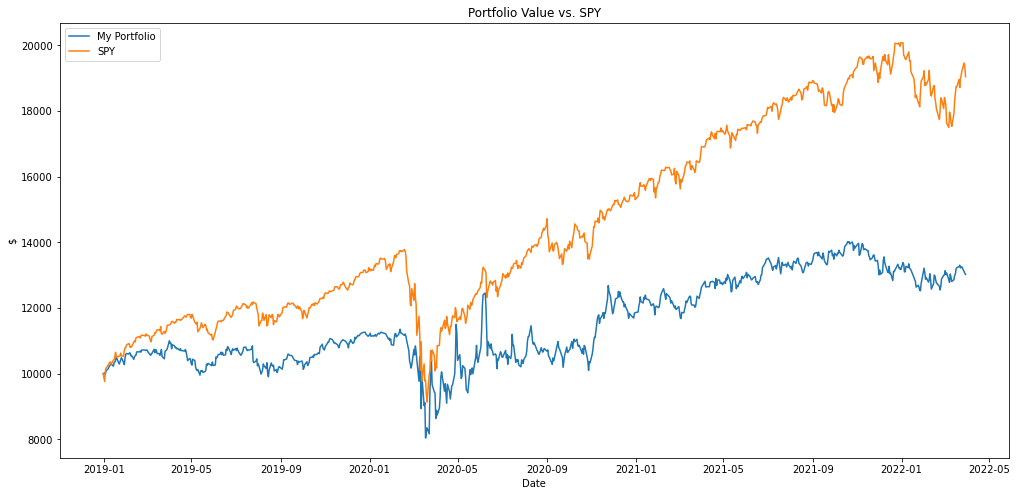

In [443]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# 30 Days After Article Date

In [33]:
tfidf_pd['nextMonthDate'] = df['Date'] + pd.DateOffset(days = 30)
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextMonthDate
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.055949,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872,2022-04-16
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728,2022-03-26
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.043471,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044,2022-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14,62.619530,2017-09-30
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.0,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12,62.335152,2017-09-28
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06,60.676292,2017-09-22
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28,62.455280,2017-08-13


In [34]:
# 30 days from current date
next_price2 = []
for i in range(len(tfidf_pd)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    next_date = tfidf_pd.iloc[i]['nextMonthDate']
    next_date = str(next_date)[0:10]
    subset = daily_prices[(daily_prices['Date'] <= next_date) & (tfidf_pd.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        next_price2.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    if subset.iloc[0]['Date'] <= str(tfidf_pd.iloc[i]['currentDate'] + pd.DateOffset(days = 7))[0:10]:
        next_price2.append(np.nan)
        continue
    next_price2.append(subset.iloc[0]['Close'])
next_price2[0]

54.11000061035156

In [35]:
tfidf_pd['nextMonthPrice'] = next_price2
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextMonthDate,nextMonthPrice
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21,54.110001
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21,54.110001
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.055949,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872,2022-04-16,54.110001
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728,2022-03-26,53.619999
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.043471,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044,2022-03-17,50.815872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14,62.619530,2017-09-30,67.141098
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12,62.335152,2017-09-28,66.534431
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06,60.676292,2017-09-22,65.719223
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28,62.455280,2017-08-13,59.169102


In [36]:
tfidf_pd = tfidf_pd.dropna()
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,996,997,998,999,Symbol,currentDate,nextDate,currentPrice,nextMonthDate,nextMonthPrice
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065416,0.061717,...,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21,54.110001
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,MO,2022-03-22,2022-04-05,52.408482,2022-04-21,54.110001
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.055949,0.000000,0.0,0.000000,MO,2022-03-17,2022-03-31,50.815872,2022-04-16,54.110001
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,MO,2022-02-24,2022-03-10,48.731728,2022-03-26,53.619999
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.043471,0.000000,0.0,0.000000,MO,2022-02-15,2022-03-01,49.469044,2022-03-17,50.815872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.043276,0.000000,0.0,0.057016,XLNX,2017-08-31,2017-09-14,62.619530,2017-09-30,67.141098
62385,0.105434,0.039807,0.000000,0.075384,0.039519,0.033299,0.0,0.040568,0.039784,0.000000,...,0.000000,0.000000,0.0,0.063488,XLNX,2017-08-29,2017-09-12,62.335152,2017-09-28,66.534431
62386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.088665,0.038557,0.0,0.023363,XLNX,2017-08-23,2017-09-06,60.676292,2017-09-22,65.719223
62387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.067731,0.000000,0.0,0.059490,XLNX,2017-07-14,2017-07-28,62.455280,2017-08-13,59.169102


In [37]:
date_split = '2018-12-30'
X_train = tfidf_pd[tfidf_pd['currentDate'] < date_split].drop(['currentDate', 'Symbol', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_train = tfidf_pd[tfidf_pd['currentDate'] < date_split]['nextMonthPrice']
X_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split].drop(['currentDate', 'Symbol', 'nextDate', 'nextMonthPrice', 'nextMonthDate'], axis = 1)
y_test = tfidf_pd[tfidf_pd['currentDate'] >= date_split]['nextMonthPrice']
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1001, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
237/237 [==============================] - 1s 2ms/step - loss: 38675.3984 - mean_absolute_error: 61.0546
Epoch 2/10
237/237 [==============================] - 0s 1ms/step - loss: 863.9828 - mean_absolute_error: 11.1882
Epoch 3/10
237/237 [==============================] - 0s 1ms/step - loss: 859.0107 - mean_absolute_error: 9.8732
Epoch 4/10
237/237 [==============================] - 0s 1ms/step - loss: 867.5073 - mean_absolute_error: 9.8347
Epoch 5/10
237/237 [==============================] - 0s 1ms/step - loss: 868.4813 - mean_absolute_error: 9.8413
Epoch 6/10
237/237 [==============================] - 0s 1ms/step - loss: 867.9016 - mean_absolute_error: 9.9221
Epoch 7/10
237/237 [==============================] - 0s 1ms/step - loss: 883.4814 - mean_absolute_error: 10.0252
Epoch 8/10
237/237 [==============================] - 0s 1ms/step - loss: 859.1508 - mean_absolute_error: 9.8769
Epoch 9/10
237/237 [==============================] - 0s 1ms/step - loss: 846.8609 - mean_a

In [38]:
# invest 10000 evenly across top projected companies equally
init_investment = 10000
predicted = pd.DataFrame(tfidf_pd.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd.loc[X_test.index]['currentDate']
predicted['Symbol'] = tfidf_pd.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,47.931667,-1.641765,53.619999,2022-02-24,MO
4,49.469044,50.903793,2.900298,50.815872,2022-02-15,MO
5,49.488705,49.173866,-0.636182,50.609425,2022-01-27,MO
6,49.488705,48.430531,-2.138213,50.609425,2022-01-27,MO
7,43.000420,41.285198,-3.988848,42.190182,2021-10-28,MO
...,...,...,...,...,...,...
62367,103.019936,103.121376,0.098467,119.622330,2019-01-24,XLNX
62368,103.019936,106.283257,3.167660,119.622330,2019-01-24,XLNX
62369,103.019936,103.175636,0.151136,119.622330,2019-01-24,XLNX
62370,103.019936,103.706909,0.666836,119.622330,2019-01-24,XLNX


In [260]:
buying_power = 10000
am = 500
value = buying_power
buy = predicted[predicted['percentChange'] > 10]
buy = buy.sort_values(by = ['articleDate'])
dates = pd.date_range(start=buy['articleDate'].min(),end=buy['articleDate'].max()+ pd.DateOffset(days = 31))
current = pd.DataFrame({})
for i in range(len(buy)):
    if buying_power > 0:
        if buying_power >= 500:
            buying_power -= 500
            symbol = buy.iloc[i]['Symbol']
            tmp = yf.Ticker(symbol)
            tmp = tmp.history(start = buy.iloc[i]['articleDate'], end = buy.iloc[i]['articleDate'] + pd.DateOffset(days = 31))
            tmp = tmp.reset_index()
            tmp = tmp[['Date', 'Close']]
            tmp['Symbol'] = symbol
            tmp['firstPrice'] = tmp.iloc[0]['Close']
            tmp['invested'] = 500
            current = current.append(tmp)
        else:
            x = buying_power
            buying_power -= x
            symbol = buy.iloc[i]['Symbol']
            tmp = yf.Ticker(symbol)
            tmp = tmp.history(start = buy.iloc[i]['articleDate'], end = buy.iloc[i]['articleDate'] + pd.DateOffset(days = 31))
            tmp = tmp.reset_index()
            tmp = tmp[['Date', 'Close']]
            tmp['Symbol'] = symbol
            tmp['firstPrice'] = tmp.iloc[0]['Close']
            tmp['invested'] = x
            current = current.append(tmp)
    
current

,Date,Close,Symbol,firstPrice,invested
0,2018-12-31,17.720112,WMB,17.720112,500
1,2019-01-02,18.017458,WMB,17.720112,500
2,2019-01-03,18.170147,WMB,17.720112,500
3,2019-01-04,18.925562,WMB,17.720112,500
4,2019-01-07,19.407742,WMB,17.720112,500
...,...,...,...,...,...
18,2019-04-04,9.619263,LUMN,9.580442,500
19,2019-04-05,9.743483,LUMN,9.580442,500
20,2019-04-08,9.727954,LUMN,9.580442,500
21,2019-04-09,9.619263,LUMN,9.580442,500


In [388]:
df_more = predicted[predicted['percentChange'] > 10]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            test2 = test.history(start=d1, end = d2)
            test2 = test2.reset_index()
            test2 = test2[['Date', 'Close']]
            test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
all_holdings
    

,Date,Close,Symbol,firstPrice,idx
0,2018-12-31,17.720112,WMB,17.720112,0
1,2019-01-02,18.017462,WMB,17.720112,0
2,2019-01-03,18.170147,WMB,17.720112,0
3,2019-01-04,18.925562,WMB,17.720112,0
4,2019-01-07,19.407742,WMB,17.720112,0
...,...,...,...,...,...
17,2022-03-24,16.719999,AAL,16.290001,306
18,2022-03-25,17.010000,AAL,16.290001,306
19,2022-03-28,17.299999,AAL,16.290001,306
20,2022-03-29,18.160000,AAL,16.290001,306


In [389]:
portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == dates[i]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
portfolio_vals

,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10008.390182
0,2019-01-03,10016.935943
0,2019-01-04,10086.633708
0,2019-01-07,10134.587841
...,...,...
0,2022-03-24,16112.686283
0,2022-03-25,16124.305228
0,2022-03-28,16133.206364
0,2022-03-29,16159.602943


In [390]:
spy = pd.read_csv("../data/SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
spy_df

,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

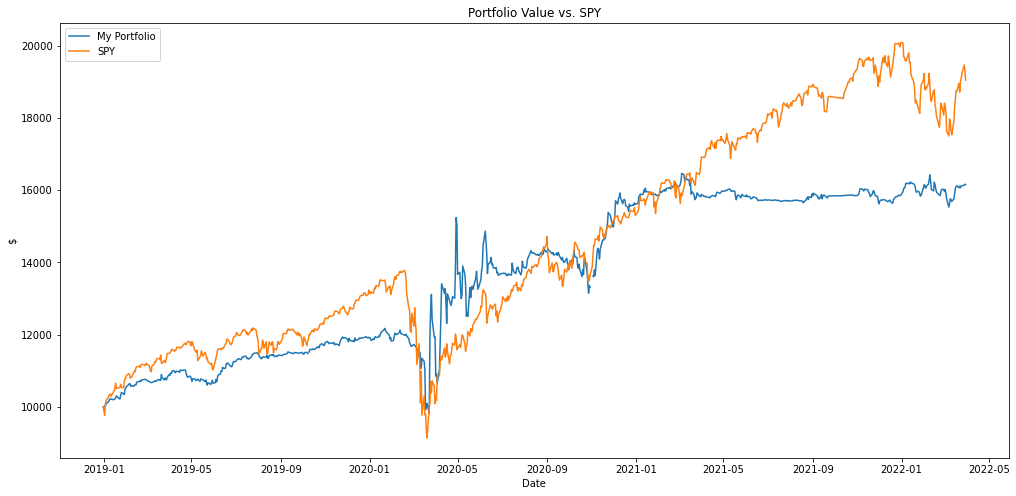

In [391]:
plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

### Buying and Shorting with TF-IDF

,Date,Close,Symbol,firstPrice,idx,BuyOrShort
979270,2018-12-31,17.954908,WMB,17.954908,0,Buy
979271,2019-01-02,18.256191,WMB,17.954908,0,Buy
979272,2019-01-03,18.410906,WMB,17.954908,0,Buy
979273,2019-01-04,19.176331,WMB,17.954908,0,Buy
979274,2019-01-07,19.664900,WMB,17.954908,0,Buy
...,...,...,...,...,...,...
458631,2022-03-24,17.049999,HPE,15.297037,351,Short
458632,2022-03-25,17.540001,HPE,15.297037,351,Short
458633,2022-03-28,17.379999,HPE,15.297037,351,Short
458634,2022-03-29,17.559999,HPE,15.297037,351,Short


,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10016.779973
0,2019-01-03,10029.634132
0,2019-01-04,10120.647330
0,2019-01-07,10182.206887
...,...,...
0,2022-03-24,15141.587896
0,2022-03-25,15167.026769
0,2022-03-28,15197.744595
0,2022-03-29,15272.423297


,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1750,452.690002,2022-03-25,1.909100,19090.998596
1751,455.910004,2022-03-28,1.922679,19226.793596
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

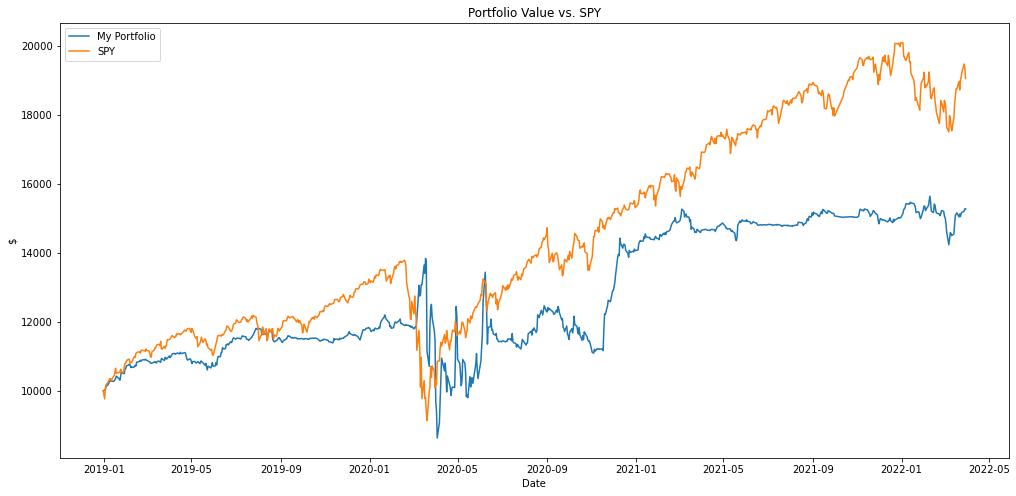

In [46]:
df_more = predicted[(predicted['percentChange'] > 10) | (predicted['percentChange'] < -15)]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if tmp.iloc[j]['percentChange'] > 20:
                if buying_power >= 1000:
                    buying_power -= 1000
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([1000])).to_frame().T
                    test2['BuyOrShort'] = 'Buy'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if tmp.iloc[j]['percentChange'] < -10:
                if buying_power >= 500:
                    buying_power -= 500
                    test = tmp.iloc[j]
                    test2 = test.append(pd.Series([500])).to_frame().T
                    test2['BuyOrShort'] = 'Short'
                    current = current.append(test2)
                    nBought += 1
                    continue
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                test2['BuyOrShort'] = 'Buy'
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            if current.iloc[j]['BuyOrShort'] == 'Buy':
                test2['BuyOrShort'] = 'Buy'
            else:
                test2['BuyOrShort'] = 'Short'
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            if tmp.iloc[j]['BuyOrShort'] == 'Buy':
                amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
            else:
                amount += (tmp.iloc[j]['firstPrice'] / tmp.iloc[j]['Close']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("../data/SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

In [42]:
current

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,BuyOrShort
0,17.490767,19.564837,11.858085,21.725031,2018-12-30,WMB,2019-01-29,500,Buy
0,17.954908,20.637711,14.941887,22.001892,2018-12-31,WMB,2019-01-30,500,Buy
0,17.954908,20.008226,11.435970,21.928602,2019-01-01,WMB,2019-01-31,500,Buy
0,30.881556,34.459042,11.584540,39.448696,2019-01-03,MU,2019-02-02,500,Buy
0,36.539612,41.302139,13.033875,41.433384,2019-01-08,AAPL,2019-02-07,500,Buy
...,...,...,...,...,...,...,...,...,...
0,32.759998,36.337772,10.921167,38.599998,2022-02-23,TWTR,2022-03-25,500,Buy
0,16.959999,20.874548,23.081068,17.010000,2022-02-24,AAL,2022-03-26,1000,Buy
0,16.290001,18.081766,10.999172,18.250000,2022-03-01,AAL,2022-03-31,500,Buy
0,16.290001,19.823675,21.692290,18.250000,2022-03-01,AAL,2022-03-31,1000,Buy


In [43]:
current[current['BuyOrShort'] == 'Short']

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol,dateSold,0,BuyOrShort
0,23.509233,19.724802,-16.097639,23.748701,2019-03-23,WMB,2019-04-22,1000,Short
0,7.849132,5.816324,-25.898511,9.014696,2019-05-24,LUMN,2019-06-23,1000,Short
0,16.690140,13.859229,-16.961576,16.055767,2019-05-31,GPS,2019-06-30,1000,Short
0,16.171923,13.528546,-16.345467,17.002600,2019-06-20,GPS,2019-07-20,1000,Short
0,15.832402,13.031667,-17.689896,17.690668,2019-06-27,GPS,2019-07-27,1000,Short
0,23.733980,19.979589,-15.818631,19.698784,2019-07-07,WMB,2019-08-06,1000,Short
0,16.450329,13.627854,-17.157557,16.124403,2019-07-11,GPS,2019-08-10,1000,Short
0,22.589403,17.914814,-20.693726,17.698524,2019-07-22,HAL,2019-08-21,1000,Short
0,16.332638,13.529082,-17.165356,14.295584,2019-08-02,GPS,2019-09-01,1000,Short
0,18.022961,13.509021,-25.045496,19.809885,2019-10-14,HAL,2019-11-13,1000,Short
